# Solving a 2D Phase field model via PINN

We want to solve the simple phase field problem of a shrinking, circular nucleus using a physics-informed neural network (PINN).

## Preliminaries

Inline Plotting

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Import relevant packages

In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tensorflow

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term






Handling of files:

In [3]:
import re
import os

## A first attempt

Define the computational domain:
$$ \Omega \in [0,100] \times [0,100] \times [0,100] $$

In [4]:
xmin = 0.0
xmax = 100.0
ymin = 0.0
ymax = 100.0
tmax = 100

radius = 20

# geom = dde.geometry.Interval(xmin, xmax)
geom = dde.geometry.Rectangle([xmin, ymin], [xmax,ymax])
timedomain = dde.geometry.TimeDomain(0, tmax)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Now, define the PDE to be solved:
- Input `x` is a tensor comprising 3 column vectors:
    - `x[:,0:1]`: $x$-Coordinate
    - `x[:,1:2]`: $y$-Coordinate
    - `x[:,2:3]`: Time $t$
- `u` is the PINN output
- We return the PDE in the form:
$$ \partial_t u - M (\Delta u + 2 \frac{\dot{g}}{\xi^2} - \frac{\mu_0}{3 \gamma_s \xi} \dot{h}) = 0$$

Given the derivatives of the double-well potential $g$ and the interpolation polynomial $h$
$$ \dot{g} = 2 u (1 - u) (1 - 2u) $$
$$ \dot{h} = 6 u (1 - u) $$

and Parameters:
- Mobility $M$ [L²/T]
- Phase Field interface width $\xi$ [L]

In [5]:
xi   = 4.0                  # [m] phasefield interface width
M    = 1.0                  # [m^2/s] kinetic coefficient
mu_0  = 0.0			        # [J/m^3] bulk energy density difference (driving force)
gamma_s = 50.0               # [J/m^2] interface energy
# Polynomials
def gprime(u):
    return 2 * u * (1.0 - u) * (1.0 - 2.0 * u)

def hprime(u):
    return 6.0 * u * (1.0 - u)

def pde(x, u):

    # Derivatives
    du_t = dde.grad.jacobian(u, x, j=2)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    div_u = du_xx + du_yy

    return (
        du_t - M * (div_u - 2*gprime(u)/xi**2 + mu_0 / (3 * gamma_s * xi)*hprime(u))
    )

We set Neumann BCs on all boundaries, i.e. we impose an adiabatic system:
$$ \nabla u = 0, \quad \forall (x,y) \in \partial \Omega $$

In [6]:
bc = dde.NeumannBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

The initial condition reads:

$$
u(r,t=0) = \frac{1}{2}\left(1 - \mathrm{tanh}\frac{r-R_0}{\xi}\right)
$$

Where $R_0$ is the radius of the nucleus and $\xi = 2a$ is the interface width.

In [7]:
def circular_ic(x): # Not needed here, legacy function to impose a sharp phase boundary
    xh = (xmax + xmin)/2
    yh = (ymax + ymin)/2
    u = np.zeros_like(x[:,0:1])
    for i in range(x.shape[0]):
        u[i] = 1.0 if (x[i,0:1] - xh)**2 + (x[i,1:2] - yh)**2 <= radius**2 else 0.0
    return u

In [8]:
def circular_nucleus(x):
    xh = (xmax + xmin)/2
    yh = (ymax + ymin)/2
    u = np.zeros_like(x[:,0:1])
    dist_to_center = np.zeros_like(x[:,0:1])
    for i in range(x.shape[0]):
        dist_to_center[i] = np.sqrt((x[i,0:1] - xh)**2 + (x[i,1:2] - yh)**2)
        u[i] = 0.5*(1.0 - np.tanh((dist_to_center[i]-radius)/xi))
    return u

In [9]:
#ic = dde.IC(geomtime, circular_ic, lambda _, on_initial: on_initial)
ic = dde.IC(geomtime, circular_nucleus, lambda _, on_initial: on_initial)

We can quickly visualize this:

No handles with labels found to put in legend.


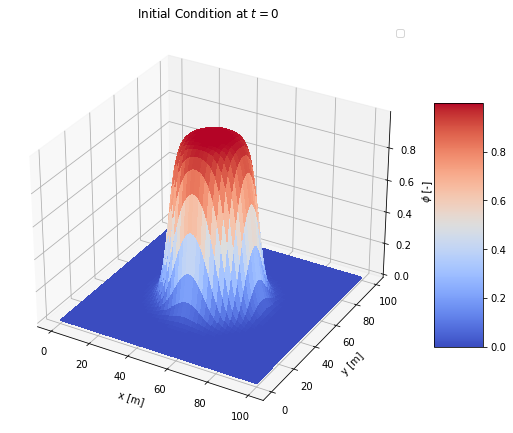

In [10]:
from mpl_toolkits.mplot3d import Axes3D

x,y = np.meshgrid(np.linspace(0,100,100),np.linspace(0,100,100))
X = np.vstack((np.ravel(x),np.ravel(y))).T

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, circular_nucleus(X).reshape(100,100),
                        cmap=mpl.cm.coolwarm, linewidth=0, antialiased=False)
ax.legend()
ax.set_title('Initial Condition at $t=0$')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('$\phi$ [-]')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Next, assemble the problem. We use 2500 training points within the domain, 80 points on the rectangular boundary and 500 points at the initial configuration.
The distribution of those training points is by default done in Monte Carlo style via a Sobol sequence.

```
@article{sobol1967distribution,
  title={On the distribution of points in a cube and the approximate evaluation of integrals},
  author={Sobol', Il'ya Meerovich},
  journal={Zhurnal Vychislitel'noi Matematiki i Matematicheskoi Fiziki},
  volume={7},
  number={4},
  pages={784--802},
  year={1967},
  publisher={Russian Academy of Sciences, Branch of Mathematical Sciences}
}
```

In [11]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2500, num_boundary=80, num_initial=500)

/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2502=2502. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserW

Set up the NN Architecture:
- 3 inputs: $x, y, t$
- 4 hidden layers with 32 neurons
- 1 output: $u(x,y,t)$
- Activation: Hyperbolic tangent $\tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}$
- Weight initialization is done via the well-known sampling method by Glorot and Bengio:
```
@InProceedings{pmlr-v9-glorot10a,
  title = 	 {Understanding the difficulty of training deep feedforward neural networks},
  author = 	 {Glorot, Xavier and Bengio, Yoshua},
  booktitle = 	 {Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics},
  pages = 	 {249--256},
  year = 	 {2010},
  editor = 	 {Teh, Yee Whye and Titterington, Mike},
  volume = 	 {9},
  series = 	 {Proceedings of Machine Learning Research},
  address = 	 {Chia Laguna Resort, Sardinia, Italy},
  month = 	 {13--15 May},
  publisher =    {PMLR},
  pdf = 	 {http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf},
  url = 	 {https://proceedings.mlr.press/v9/glorot10a.html},
  abstract = 	 {Whereas before 2006 it appears that deep multi-layer neural networks were not successfully trained, since then several algorithms have been shown to successfully train them, with experimental results showing the superiority of deeper vs less deep architectures. All these experimental results were obtained with new initialization or training mechanisms. Our objective here is to understand better why standard gradient descent from random initialization is doing so poorly with deep neural networks, to better understand these recent relative successes and help design better algorithms in the future.  We first observe the influence of the non-linear activations functions. We find that the logistic sigmoid activation is unsuited for deep networks with random initialization because of its mean value, which can drive especially the top hidden layer into saturation. Surprisingly, we find that saturated units can move out of saturation by themselves, albeit slowly, and explaining the plateaus sometimes seen when training neural networks. We find that a new non-linearity that saturates less can often be beneficial. Finally, we study how activations and gradients vary across layers and during training, with the idea that training may be more difficult when the singular values of the Jacobian associated with each layer are far from 1.  Based on these considerations, we propose a new initialization scheme that brings substantially faster convergence.}
}
```

In [12]:
net = dde.nn.FNN([3] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

Build and train the model.
First, we use the momentum-driven `ADAM` optimizer as it's simple and robust enough to get us in the neighborhood of an optimum. The Learning rate of 0.001 is popular enough so that we simply adapt it without further insight.
Next, we do additional training with the memory-limited `BFGS` optimizer. This as a quasi-newton method makes additional use of an approximate inverse hessian (i.e. second derivatives instead of only first) to speed up convergence. However, `L-BFGS` is somewhat prone to getting stuck at bad local minima. Hence, we employ it only later in the training process.

In order to abort training when there is no further progress, we employ an early stopping callback that watches the loss evolution of the last 4000 epochs. We also write out the NN parameters every 5000 epochs and save the last version separately on disk.

In [13]:
# Save models
checker = dde.callbacks.ModelCheckpoint(
    "model/unscaled/model-unscaled.ckpt", save_better_only=True, period=5000
)

model.compile("adam", lr=1e-3)#, loss_weights=[0.1,1000])
model.train(epochs=20000, callbacks=[checker])
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-8, patience=4000)
# Increase the BC loss weight
model.compile("L-BFGS")#, loss_weights=[0.1,1000])
losshistory, trainstate = model.train(epochs=5000, callbacks=[early_stopping, checker], model_save_path='model/unscaled-last.ckpt')


/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Compiling model...
Building feed-forward neural network...
'build' took 0.090011 s



2021-12-17 09:29:07.093961: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.551515 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.77e-02, 4.46e-04, 2.20e-01]    [1.77e-02, 4.46e-04, 2.20e-01]    []  


2021-12-17 09:29:07.564602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-17 09:29:07.574650: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1992000000 Hz


1000      [4.45e-04, 3.07e-05, 6.40e-03]    [4.45e-04, 3.07e-05, 6.40e-03]    []  
2000      [3.08e-04, 1.87e-05, 5.59e-04]    [3.08e-04, 1.87e-05, 5.59e-04]    []  
3000      [2.15e-04, 8.72e-06, 7.78e-05]    [2.15e-04, 8.72e-06, 7.78e-05]    []  
4000      [1.64e-04, 6.56e-06, 3.88e-05]    [1.64e-04, 6.56e-06, 3.88e-05]    []  
5000      [1.41e-04, 6.33e-06, 2.29e-05]    [1.41e-04, 6.33e-06, 2.29e-05]    []  
INFO:tensorflow:model/unscaled/model-unscaled.ckpt-5000 is not in all_model_checkpoint_paths. Manually adding it.
6000      [1.14e-04, 2.24e-06, 4.53e-05]    [1.14e-04, 2.24e-06, 4.53e-05]    []  
7000      [9.92e-05, 2.34e-06, 1.14e-05]    [9.92e-05, 2.34e-06, 1.14e-05]    []  
8000      [8.09e-05, 2.63e-06, 1.18e-05]    [8.09e-05, 2.63e-06, 1.18e-05]    []  
9000      [4.96e-05, 9.97e-07, 1.71e-04]    [4.96e-05, 9.97e-07, 1.71e-04]    []  
10000     [4.40e-05, 7.57e-07, 3.09e-05]    [4.40e-05, 7.57e-07, 3.09e-05]    []  
INFO:tensorflow:model/unscaled/model-unscaled.ckpt-10000

 Let's visualize the model convergence. We can observe a sudden decline in the loss around epoch 20,000. That is the point where we switched the optimizer to `L-BFGS`.

Saving loss history to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/loss.dat ...
Saving training data to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/train.dat ...
Saving test data to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/test.dat ...


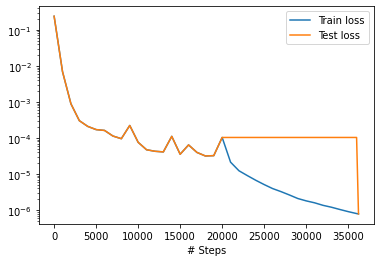

In [14]:
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)

We can now do some inference using our trained model and compare it to a reference solution.

First, we will generate a separate set of points that is evenly distributed within our spatio-temporal domain:

We can now apply the model on our dataset using `model.predict()`.

To supply the data in a format that can be handled by the model, we need to pass it as a `N x 3` Tensor with `N` grid points and the columns holding the `x`, `y`, and `t` values. We ask the solution for $t=100$. Hence, we need to append another vector to `X` in the horizontal direction that assigns each grid point the desired time.

All the reshaping is needed in order to supply `matplotlib` with the arrays in a suitable format. The NN output has shape (10,000x1), but we need it to be in a cartesian meshgrid format. So we need to transform the output from the contiguous form the NN outputs to the cartesian form.

In [15]:
time = 100.0
# If you don't want to train again, just use the trained model on disk
# dde.model.Model.restore(model, "model/unscaled-last.ckpt-27027", verbose=1)

x,y = np.meshgrid(np.linspace(0,100,100),np.linspace(0,100,100))
X = np.vstack((np.ravel(x),np.ravel(y))).T
t_1 = np.full(10000,time).reshape(10000,1)
Xt_1 = np.hstack((X, t_1))
phi_pred = model.predict(Xt_1).reshape(100,100)

Note that the forward (inference) pass is orders of magnitude faster than training. In this case the difference is in the order of $10^4$.

No handles with labels found to put in legend.
/tmp/ipykernel_23114/3085398453.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(surf, shrink=0.5, aspect=5)


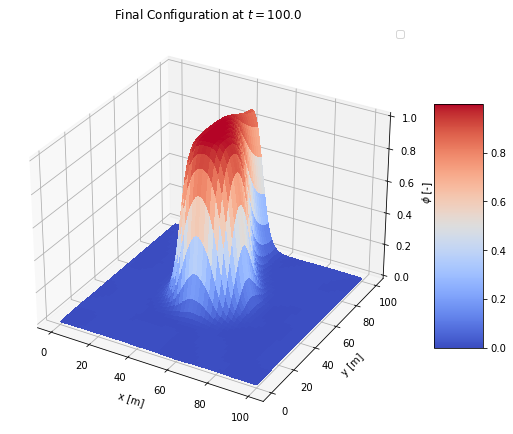

In [16]:

fig = plt.figure(figsize=(9, 9))
ax2 = fig.add_subplot(111, projection='3d')
surf2 = ax2.plot_surface(x, y, phi_pred,
                            cmap=mpl.cm.coolwarm, linewidth=0, antialiased=False)
ax2.legend()
ax2.set_title(f'Final Configuration at $t={time}$')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')
ax2.set_zlabel('$\phi$ [-]')
ax2.set_zlim(0,1)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

This looks like a lot of garbage. Even with a large amount of boundary and initial points, we get unphysical disturbances in the field, i.e. we have locations outside the initial grain that assume phase values with $\phi \neq 0$.

## Same problem, different scaling

An often considered problem in PINNs is inproper scaling of the problem definition. This can cause numerical issues, especially during backpropagation. We will now try to rescale it such that the domain is of size:

$$ \Omega \in [0,1] \times [0,1] \times [0,1] $$

For this to work, we need to re-scale all coefficients that involve length and time scales as well.

We first redefine the domain as such:

In [17]:
xmin_s = 0.0
xmax_s = 1.0
ymin_s = 0.0
ymax_s = 1.0
tmax_s = 1.0

radius_s = 0.2

geom_s = dde.geometry.Rectangle([xmin_s, ymin_s], [xmax_s,ymax_s])
timedomain_s = dde.geometry.TimeDomain(0, tmax_s)
geomtime_s = dde.geometry.GeometryXTime(geom_s, timedomain_s)

As we have now scaled the domain down in all two spatial directions by a factor of $100$ and the time domain by $100$, we need to give the coefficients the same treatment. To do this, we need to look at the units of these quantities.

To scale units that involve energy properly, we need to re-write those:

$$ \frac{J}{m^3} = \frac{kg \cdot m^2}{s^2} \cdot \frac{1}{m^3} = \frac{kg}{m\cdot s^2} \propto \frac{1}{m \cdot s^2} $$

For the interface energy, we obtain in the same manner:

$$ \frac{J}{m^2} \propto \frac{1}{s^2} $$

As our coefficient scaling has changed, we need to re-define the pde function as well:

In [18]:
scale_space = 0.01
scale_time = 0.01

# The coefficients
xi_s       = xi * scale_space                       # [m] phasefield interface width
M_s        = M * (scale_space**2/scale_time)       # [m^2/s] kinetic coefficient
mu_0_s     = mu_0 * 1/(scale_space*scale_time**2)     # [J/m^3 = kg/(m s^2)]  bulk energy density difference (driving force)
gamma_s_s  = gamma_s * 1/(scale_time**2)                # [J/m^2 = kg/(s^2)] interface energy

def pde_s(x, u):
    # Derivatives
    du_t = dde.grad.jacobian(u, x, j=2)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    div_u = du_xx + du_yy

    return (
        du_t - M_s * (div_u - 2*gprime(u)/xi_s**2 + mu_0_s / (3 * gamma_s_s * xi_s)*hprime(u))
    )

In [19]:
def circular_nucleus_s(x):
    xh = (xmax_s + xmin_s)/2
    yh = (ymax_s + ymin_s)/2
    u = np.zeros_like(x[:,0:1])
    dist_to_center = np.zeros_like(x[:,0:1])
    for i in range(x.shape[0]):
        dist_to_center[i] = np.sqrt((x[i,0:1] - xh)**2 + (x[i,1:2] - yh)**2)
        u[i] = 0.5*(1.0 - np.tanh((dist_to_center[i]-radius_s)/xi_s))
    return u

We can leave the definitions of the polynomials untouched. However, we need to reset the BCs and IC. We can also plot the IC once again to make sure we re-mapped the domain correctly.

/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2502=2502. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserW

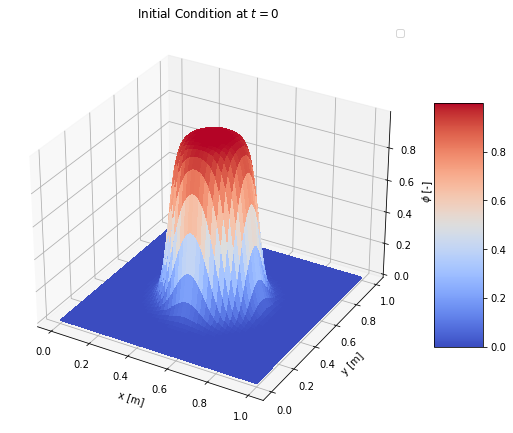

In [32]:
bc_s = dde.NeumannBC(geomtime_s, lambda x: 0, lambda _, on_boundary: on_boundary)
ic_s = dde.IC(geomtime_s, circular_nucleus_s, lambda _, on_initial: on_initial)
data_s = dde.data.TimePDE(geomtime_s, pde_s, [bc_s, ic_s], num_domain=2500, num_boundary=80, num_initial=500)

x_s,y_s = np.meshgrid(np.linspace(xmin_s,xmax_s,100),np.linspace(ymin_s,ymax_s,100))
X_s = np.vstack((np.ravel(x_s),np.ravel(y_s))).T

fig = plt.figure(figsize=(9, 9))
ax3 = fig.add_subplot(111, projection='3d')
surf3 = ax3.plot_surface(x_s, y_s, circular_nucleus_s(X_s).reshape(100,100), cmap=mpl.cm.coolwarm,
                        linewidth=0, antialiased=False)
ax3.legend()
ax3.set_title('Initial Condition at $t=0$')
ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_zlabel('$\phi$ [-]')
fig.colorbar(surf3, shrink=0.5, aspect=5)

plt.show()

Finally, we re-initialize the model and train it once again using the exact same strategy.

In [33]:
net_s = dde.nn.FNN([3] + [32] * 4 + [1], "tanh", "Glorot normal")
model_s = dde.Model(data_s, net_s)

In [34]:
# Save models
checker_s = dde.callbacks.ModelCheckpoint(
    "model/scaled/model-scaled.ckpt", save_better_only=True, period=5000
)

model_s.compile("adam", lr=1e-3)#, loss_weights=[0.1,1000])
model_s.train(epochs=20000, callbacks=[checker_s])
early_stopping_s = dde.callbacks.EarlyStopping(min_delta=1e-8, patience=10000)
# Increase the BC loss weight
model_s.compile("L-BFGS")#, loss_weights=[0.1,1000])
losshistory_s, trainstate_s = model_s.train(epochs=5000, callbacks=[early_stopping_s, checker_s], model_save_path='model/scaled-last.ckpt')

Compiling model...
Building feed-forward neural network...
'build' took 0.080477 s



/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.664106 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.07e+00, 1.59e-02, 1.36e-01]    [5.07e+00, 1.59e-02, 1.36e-01]    []  
1000      [1.96e-04, 1.16e-05, 1.06e-01]    [1.96e-04, 1.16e-05, 1.06e-01]    []  
2000      [2.35e-04, 1.09e-05, 1.06e-01]    [2.35e-04, 1.09e-05, 1.06e-01]    []  
3000      [2.15e-04, 1.02e-05, 1.06e-01]    [2.15e-04, 1.02e-05, 1.06e-01]    []  


KeyboardInterrupt: 

Saving loss history to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/loss.dat ...
Saving training data to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/train.dat ...
Saving test data to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/test.dat ...


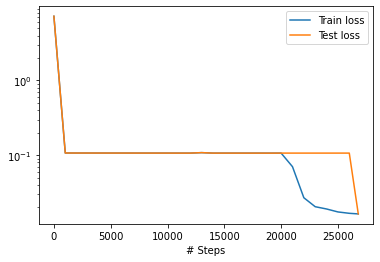

In [ ]:
dde.saveplot(losshistory_s, trainstate_s, issave=True, isplot=True)

Now, let's query the solution once again in our normalized domain using 100 grid points in each direction:

No handles with labels found to put in legend.
/tmp/ipykernel_23114/2835304957.py:21: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(surf3, shrink=0.5, aspect=5)


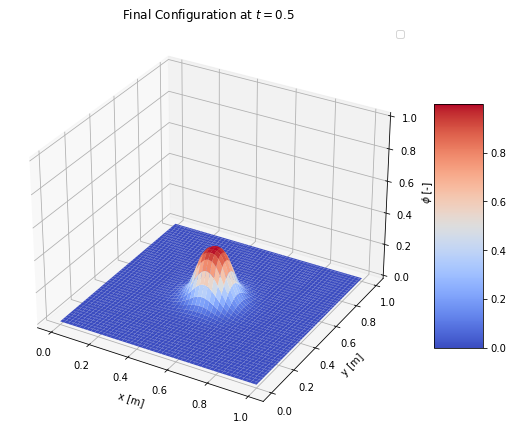

In [ ]:
time = 1.0

# If you don't want to train again, just use the trained model on disk
#dde.Model.restore(model2, "model/scaled-last.ckpt", verbose=1)

x_s,y_s = np.meshgrid(np.linspace(xmin_s,xmax_s,100),np.linspace(ymin_s,ymax_s,100))
X_s = np.vstack((np.ravel(x_s),np.ravel(y_s))).T
t_s = np.full(10000,time).reshape(10000,1)
Xt_s = np.hstack((X_s, t_s))
phi_pred_s = model_s.predict(Xt_s).reshape(100,100)

fig = plt.figure(figsize=(9, 9))
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot_surface(x_s, y_s, phi_pred_s, cmap=mpl.cm.coolwarm)
ax2.legend()
ax2.set_title(f'Final Configuration at $t={time}$')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')
ax2.set_zlabel('$\phi$ [-]')
ax2.set_zlim(0,1)
fig.colorbar(surf3, shrink=0.5, aspect=5)

plt.show()

The solution differs from the previous one, but still is fundamentally wrong. The prediction within the domain is that the phase field assumes a roughly uniform distribution.

Ignoring the fluctuations in the field, this looks roughly as if the PDE describes simple diffusion - which is what you would get if you were to ignore all the source terms in our model. Thus we could suspect that the polynomial sources that encode the driving forces are not properly accounted for.

## Modifying the PDE formulation

In [other, more physically complex examples](https://github.com/lululxvi/deepxde/blob/master/examples/Beltrami_flow.py) in `DeepXDE`, the output `u` is split and assigned to separate objects in the PDE formulation. It could be that this is necessary as well when computing functions of the output in the PDE, even if `u` is a scalar quantity. In previous numerical experiments `DeepXDE` has also exhibited the behaviour of silently ignoring BC terms it cannot compute instead of throwing errors, so this could also be the case for PDE terms. Let's try that.

We will adapt most of the formulation from the normalized domain and only adapt what's necessary, i.e. the PDE function

In [ ]:
def pde_sc(x, u):
    def gprime(u):
        return 2 * u * (1.0 - u) * (1.0 - 2.0 * u)

    def hprime(u):
        return 6.0 * u * (1.0 - u)

    # Derivatives
    du_t = dde.grad.jacobian(u, x, j=2)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)

    # Assign the output
    phi = u[:,0:1]

    return (
        du_t - M_s * (du_xx + du_yy
                      - 2 * 2 * phi * (1.0 - phi) * (1.0 - 2.0 * phi) / xi_s**2
                      + mu_0_s / (3 * gamma_s_s * xi_s) * 6.0 * phi * (1.0 - phi)
                    )
    )

In [ ]:
data_sc = dde.data.TimePDE(geomtime_s, pde_sc, [bc_s, ic_s], num_domain=2500, num_boundary=80, num_initial=500)

/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2502=2502. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserW

In [ ]:
net_sc = dde.nn.FNN([3] + [32] * 4 + [1], "tanh", "Glorot normal")
model_sc = dde.Model(data_sc, net_sc)

# Save models
checker_sc = dde.callbacks.ModelCheckpoint(
    "model/scaled-custom/model-scaled-custom.ckpt", save_better_only=True, period=5000
)

model_sc.compile("adam", lr=1e-3)#, loss_weights=[0.1,1000])
model_sc.train(epochs=20000, callbacks=[checker_sc])
early_stopping_sc = dde.callbacks.EarlyStopping(min_delta=1e-8, patience=40000)
# Increase the BC loss weight
model_sc.compile("L-BFGS")#, loss_weights=[0.1,1000])
losshistory_sc, trainstate_sc = model_sc.train(epochs=5000, callbacks=[early_stopping_s, checker_s], model_save_path='model/scaled-custom-last.ckpt')

/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/zimbropa/anaconda3/envs/pinn/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Compiling model...
Building feed-forward neural network...
'build' took 0.100773 s

'compile' took 0.806879 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.85e+02, 2.37e-01, 2.70e-01]    [4.85e+02, 2.37e-01, 2.70e-01]    []  
1000      [1.20e-02, 1.91e-03, 2.20e-01]    [1.20e-02, 1.91e-03, 2.20e-01]    []  
2000      [6.96e-03, 1.22e-03, 2.20e-01]    [6.96e-03, 1.22e-03, 2.20e-01]    []  
3000      [4.40e-03, 5.97e-04, 2.21e-01]    [4.40e-03, 5.97e-04, 2.21e-01]    []  
4000      [3.00e-03, 2.65e-04, 2.21e-01]    [3.00e-03, 2.65e-04, 2.21e-01]    []  
5000      [2.40e-03, 1.24e-04, 2.21e-01]    [2.40e-03, 1.24e-04, 2.21e-01]    []  
INFO:tensorflow:model/scaled-custom/model-scaled-custom.ckpt-5000 is not in all_model_checkpoint_paths. Manually adding it.
6000      [2.20e-03, 6.62e-05, 2.22e-01]    [2.20e-03, 6.62e-05, 2.22e-01]    []  
7000      [2.14e-03, 4.40e-05, 2.22e-01]    [2.14

Saving loss history to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/loss.dat ...
Saving training data to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/train.dat ...
Saving test data to /home/zimbropa/GitHub/ml-for-phasefield/models/PINN/test.dat ...


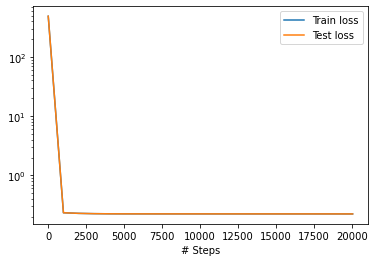

In [ ]:
dde.saveplot(losshistory_sc, trainstate_sc, issave=True, isplot=True)

With the new model trained, let's again visualize the results.

No handles with labels found to put in legend.
/tmp/ipykernel_23114/1453472867.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(surf3, shrink=0.5, aspect=5)


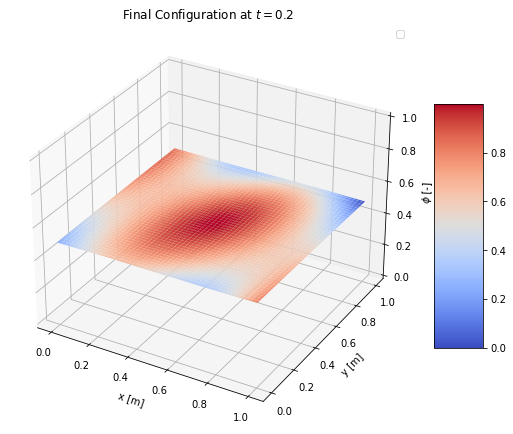

In [ ]:
phi_pred_sc = model_sc.predict(Xt_s).reshape(100,100)

fig = plt.figure(figsize=(9, 9))
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot_surface(x_s, y_s, phi_pred_sc, cmap=mpl.cm.coolwarm)
ax3.legend()
ax3.set_title(f'Final Configuration at $t={time}$')
ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_zlabel('$\phi$ [-]')
ax3.set_zlim(0,1)
fig.colorbar(surf3, shrink=0.5, aspect=5)

plt.show()